## Processing Sequences Using RNNs

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


# A. Basic Recurrent Neural Networks

## Generate the Dataset

Let's generate some data to play with Recurrent Neural Network. We will generate 10,000 data that contains 7,000 train data, 2,000 validation data, and 1,000 test data.

In [ ]:
# Function or Generate Data. The Generated Data is Assumed to be Time Series Data
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [ ]:
# Generate Dataset that Each Row/Data Contains 20 Features/Columns/Time Step

np.random.seed(42)

n_steps = 20
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [ ]:
# Display the First Two Data

print('X_train - 0 : ', X_train[0])
print('y_train - 0 : ', y_train[0])
print('')

print('X_train - 1 : ', X_train[1])
print('y_train - 1 : ', y_train[1])
print('')

X_train - 0 :  [[ 0.4596948 ]
 [ 0.00755453]
 [-0.5432616 ]
 [-0.6779426 ]
 [-0.34988356]
 [ 0.00858441]
 [ 0.13068825]
 [ 0.23212491]
 [ 0.44191158]
 [ 0.48522508]
 [ 0.17225628]
 [-0.43605506]
 [-0.6329039 ]
 [-0.33909634]
 [-0.03571324]
 [ 0.14223886]
 [ 0.21056868]
 [ 0.39458805]
 [ 0.46924356]
 [ 0.24145903]]
y_train - 0 :  [-0.4072814]

X_train - 1 :  [[ 0.3338718 ]
 [-0.0208375 ]
 [-0.45994148]
 [-0.53118634]
 [ 0.03263218]
 [ 0.584183  ]
 [ 0.5420556 ]
 [-0.05551102]
 [-0.6485825 ]
 [-0.50053525]
 [ 0.1468956 ]
 [ 0.46564335]
 [ 0.37931484]
 [-0.00969904]
 [-0.27577117]
 [-0.26779324]
 [-0.15419051]
 [ 0.03101839]
 [ 0.3415931 ]
 [ 0.44874772]]
y_train - 1 :  [0.11540564]



Saving figure time_series_plot


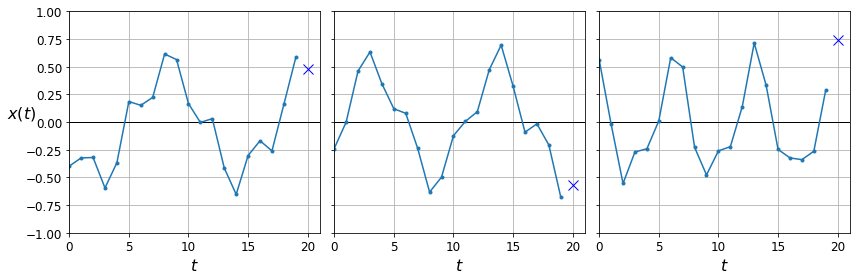

In [ ]:
# Visualization of the First Three Data

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

Symbol `X` in graph above indicates the target (`y`).

---

## Computing Some Baselines

Before we start using RNNs, it is often a good idea to have a few baseline
metrics/models. Reasons : 
* We may end up thinking our model works great when **in fact it is doing worse** than basic models. 
* Basic models will be our reference in making the model where the model we make **must have a smaller error value** compare to error of basic model.
* In this case, the simplest
approach is to **predict the last value** in each series. This is called naive forecasting, and it is sometimes surprisingly difficult to outperform.

In [ ]:
# Compute Last Value as Predictions

y_pred = X_valid[:, -1]
mse_last_value = np.mean(keras.losses.mean_squared_error(y_valid, y_pred))
print('MSE - Last Value : ', mse_last_value)

MSE - Last Value :  0.11083336


In [ ]:
# Display Predictions for First Data

print('X_valid[0] : ', X_valid[0])
print('y_pred[0]  : ', y_pred[0])
print('y_valid[0] : ', y_valid[0])

X_valid[0] :  [[-0.39738172]
 [-0.32362208]
 [-0.31975183]
 [-0.5947493 ]
 [-0.36596888]
 [ 0.18584815]
 [ 0.15152901]
 [ 0.2231278 ]
 [ 0.6153976 ]
 [ 0.5645286 ]
 [ 0.1671722 ]
 [-0.00300609]
 [ 0.03139698]
 [-0.4140219 ]
 [-0.6529177 ]
 [-0.3021427 ]
 [-0.1683889 ]
 [-0.26021743]
 [ 0.15992366]
 [ 0.58405554]]
y_pred[0]  :  [0.58405554]
y_valid[0] :  [0.47945035]


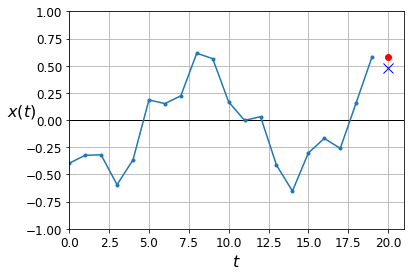

In [ ]:
# Visualization of Predictions for First Data

plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In the graph above, `X` means the target (`y_valid`) meanwhile `red-dot` is our prediction (`y_pred`)

---

## Simple Neural Network

Let's solve this problem using Neural Network. This time we will solve it by using only 1 input layer and 1 output layer where the **output neurons are only 1**.

In [ ]:
# Let's Try Solve the Problem using Simple Neural Network

%%time
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[20, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

Epoch 1/100
219/219 [==============================] - 1s 2ms/step - loss: 0.2294 - val_loss: 0.1467
Epoch 2/100
219/219 [==============================] - 0s 1ms/step - loss: 0.1081 - val_loss: 0.0980
Epoch 3/100
219/219 [==============================] - 0s 1ms/step - loss: 0.0775 - val_loss: 0.0718
Epoch 4/100
219/219 [==============================] - 0s 1ms/step - loss: 0.0592 - val_loss: 0.0553
Epoch 5/100
219/219 [==============================] - 0s 1ms/step - loss: 0.0469 - val_loss: 0.0435
Epoch 6/100
219/219 [==============================] - 0s 1ms/step - loss: 0.0381 - val_loss: 0.0357
Epoch 7/100
219/219 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0299
Epoch 8/100
219/219 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.0258
Epoch 9/100
219/219 [==============================] - 0s 1ms/step - loss: 0.0243 - val_loss: 0.0230
Epoch 10/100
219/219 [==============================] - 0s 1ms/step - loss: 0.0219 - val_lo

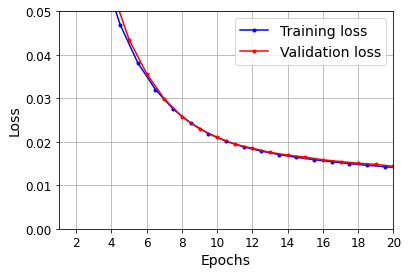

In [ ]:
# Visualization of Training Loss and Validation Loss

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
# Architecture of Our Simple Neural Network

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compute MSE and Compare to MSE from Naive Forecasting (using Last Value)

mse_simple_nn = model.evaluate(X_valid, y_valid)

print('MSE - Last Value            : ', mse_last_value)
print('MSE - Simple Neural Network : ', mse_simple_nn)

63/63 [==============================] - 0s 863us/step - loss: 0.0118
MSE - Last Value            :  0.11083336
MSE - Simple Neural Network :  0.011821746826171875


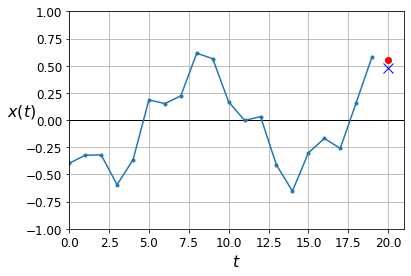

In [ ]:
# Visualization of Predictions for First Data

y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In the graph above, `X` means the target (`y_valid`) meanwhile `red-dot` is our prediction (`y_pred`)

---

## Using a Simple Recurrent Neural Network (RNN)

Let's try solve this problem using simple Recurrent Neural Network. This time we will solve it by using **only 1 RNN's neuron**.

In [ ]:
# Let's Try Solve the Problem using Simple Recurrent Neural Network

%%time
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[20, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
219/219 [==============================] - 2s 5ms/step - loss: 0.1698 - val_loss: 0.1326
Epoch 2/100
219/219 [==============================] - 1s 4ms/step - loss: 0.1039 - val_loss: 0.0864
Epoch 3/100
219/219 [==============================] - 1s 4ms/step - loss: 0.0690 - val_loss: 0.0602
Epoch 4/100
219/219 [==============================] - 1s 4ms/step - loss: 0.0514 - val_loss: 0.0479
Epoch 5/100
219/219 [==============================] - 1s 4ms/step - loss: 0.0452 - val_loss: 0.0450
Epoch 6/100
219/219 [==============================] - 1s 4ms/step - loss: 0.0443 - val_loss: 0.0446
Epoch 7/100
219/219 [==============================] - 1s 4ms/step - loss: 0.0442 - val_loss: 0.0445
Epoch 8/100
219/219 [==============================] - 1s 4ms/step - loss: 0.0442 - val_loss: 0.0446
Epoch 9/100
219/219 [==============================] - 1s 4ms/step - loss: 0.0442 - val_loss: 0.0445
Epoch 10/100
219/219 [==============================] - 1s 4ms/step - loss: 0.0442 - val_lo

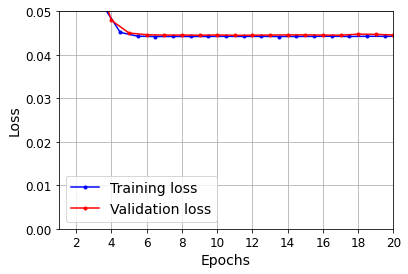

In [ ]:
# Visualization of Training Loss and Validation Loss

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
# Architecture of Our Simple Recurrent Neural Network

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compute MSE and Compare to MSE from Naive Forecasting (using Last Value) and from Simple Neural Network

mse_simple_rnn = model.evaluate(X_valid, y_valid)

print('\nMSE - Last Value                      : ', mse_last_value)
print('MSE - Simple Neural Network           : ', mse_simple_nn)
print('MSE - Simple Recurrent Neural Network : ', mse_simple_rnn)

63/63 [==============================] - 0s 2ms/step - loss: 0.0445

MSE - Last Value                      :  0.11083336
MSE - Simple Neural Network           :  0.011821746826171875
MSE - Simple Recurrent Neural Network :  0.0445365346968174


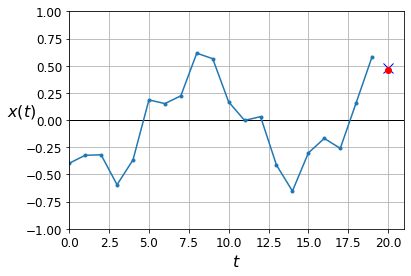

In [ ]:
# Visualization of Predictions for First Data

y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In the graph above, `X` means the target (`y_valid`) meanwhile `red-dot` is our prediction (`y_pred`)

---

## Using Deep Recurrent Neural Network

This time we will solve it by using RNN neurons where we will stack multiple layers of RNN.

Note : Make sure to set `return_sequences=True` for all recurrent layers (except the last one, if you only care about the last output). If you don’t, they will output a 2D array (containing only the output of the last time step) instead of a 3D array (containing outputs for all time steps), and the next recurrent layer will complain that you are not feeding it sequences in the expected 3D format.


In [ ]:
# Let's Try Solve the Problem using Deep Recurrent Neural Network

%%time
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

Epoch 1/100
219/219 [==============================] - 5s 14ms/step - loss: 0.0523 - val_loss: 0.0138
Epoch 2/100
219/219 [==============================] - 3s 12ms/step - loss: 0.0120 - val_loss: 0.0120
Epoch 3/100
219/219 [==============================] - 3s 12ms/step - loss: 0.0093 - val_loss: 0.0098
Epoch 4/100
219/219 [==============================] - 3s 13ms/step - loss: 0.0083 - val_loss: 0.0083
Epoch 5/100
219/219 [==============================] - 3s 13ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 6/100
219/219 [==============================] - 3s 13ms/step - loss: 0.0077 - val_loss: 0.0072
Epoch 7/100
219/219 [==============================] - 3s 13ms/step - loss: 0.0071 - val_loss: 0.0074
Epoch 8/100
219/219 [==============================] - 3s 13ms/step - loss: 0.0073 - val_loss: 0.0069
Epoch 9/100
219/219 [==============================] - 3s 13ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 10/100
219/219 [==============================] - 3s 12ms/step - loss: 0.006

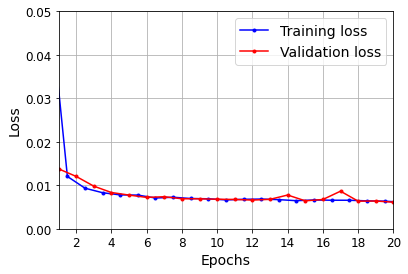

In [ ]:
# Visualization of Training Loss and Validation Loss

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
# Compute MSE and Compare to MSE from Naive Forecasting (using Last Value), Simple Neural Network, and from Simple Recurrent Neural Network

mse_deep_rnn = model.evaluate(X_valid, y_valid)

print('\nMSE - Last Value                      : ', mse_last_value)
print('MSE - Simple Neural Network           : ', mse_simple_nn)
print('MSE - Simple Recurrent Neural Network : ', mse_simple_rnn)
print('MSE - Deep Recurrent Neural Network   : ', mse_deep_rnn)

63/63 [==============================] - 0s 3ms/step - loss: 0.0029

MSE - Last Value                      :  0.11083336
MSE - Simple Neural Network           :  0.011821746826171875
MSE - Simple Recurrent Neural Network :  0.0445365346968174
MSE - Deep Recurrent Neural Network   :  0.0028947098180651665


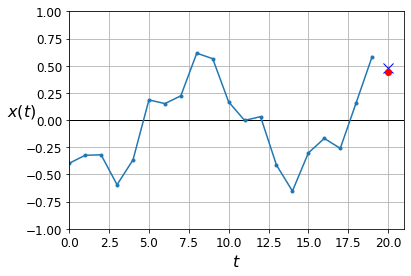

In [ ]:
# Visualization of Predictions for First Data

y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

---
Let's change last layer to Dense Layer. This is because :
* In real-world application, **it is rare** that output layer is recurrent neurons. 
* Also, since **a SimpleRNN layer uses the tanh activation function** by default, the predicted values must lie within the range –1 to 1. But what if you want to use another activation function? 

For both these reasons, it might be preferable to replace the output layer with a Dense layer: it would run slightly faster, the accuracy would be roughly the same, and it would allow us to choose any output activation function we want. 

If you make this change, also make sure to remove `return_sequences=True` from the second (now last) recurrent layer.

In [ ]:
# Let's Try Solve the Problem using Deep Recurrent Neural Network with Dense Layer as Last Layer

%%time
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

Epoch 1/100
219/219 [==============================] - 4s 10ms/step - loss: 0.0514 - val_loss: 0.0126
Epoch 2/100
219/219 [==============================] - 2s 9ms/step - loss: 0.0107 - val_loss: 0.0094
Epoch 3/100
219/219 [==============================] - 2s 8ms/step - loss: 0.0091 - val_loss: 0.0086
Epoch 4/100
219/219 [==============================] - 2s 8ms/step - loss: 0.0086 - val_loss: 0.0086
Epoch 5/100
219/219 [==============================] - 2s 9ms/step - loss: 0.0082 - val_loss: 0.0076
Epoch 6/100
219/219 [==============================] - 2s 9ms/step - loss: 0.0080 - val_loss: 0.0075
Epoch 7/100
219/219 [==============================] - 2s 8ms/step - loss: 0.0073 - val_loss: 0.0078
Epoch 8/100
219/219 [==============================] - 2s 9ms/step - loss: 0.0073 - val_loss: 0.0070
Epoch 9/100
219/219 [==============================] - 2s 9ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 10/100
219/219 [==============================] - 2s 9ms/step - loss: 0.0071 - val_l

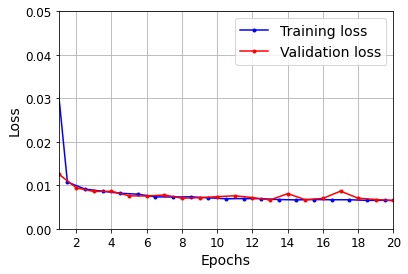

In [ ]:
# Visualization of Training Loss and Validation Loss

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
# Compute MSE and Compare to MSE from Naive Forecasting (using Last Value), Simple Neural Network, Simple Recurrent Neural Network, and Deep Recurrent Neural Network

mse_deep_rnn_dense = model.evaluate(X_valid, y_valid)

print('\nMSE - Last Value                                  : ', mse_last_value)
print('MSE - Simple Neural Network                       : ', mse_simple_nn)
print('MSE - Simple Recurrent Neural Network             : ', mse_simple_rnn)
print('MSE - Deep Recurrent Neural Network               : ', mse_deep_rnn)
print('MSE - Deep Recurrent Neural Network - Dense Layer : ', mse_deep_rnn_dense)

63/63 [==============================] - 0s 3ms/step - loss: 0.0032

MSE - Last Value                                  :  0.11083336
MSE - Simple Neural Network                       :  0.011821746826171875
MSE - Simple Recurrent Neural Network             :  0.0445365346968174
MSE - Deep Recurrent Neural Network               :  0.0028947098180651665
MSE - Deep Recurrent Neural Network - Dense Layer :  0.0032483567483723164


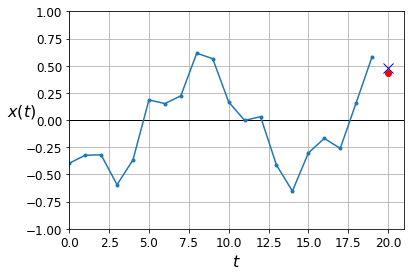

In [ ]:
# Visualization of Predictions for First Data

y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Notes:

* Although the MSE value of `RNN-Dense` layers has a larger error than `RNN` layers only, this **error is still in approximately the same range**.

* We can see that with `RNN-Dense` layers, the **processing time is faster** (3 minutes 18 seconds) than using `RNN` layers only (4 minutes 39 seconds).

# B. LSTMs

In [ ]:
# Let's Try Solve the Problem using LSTM

%%time
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

Epoch 1/100
219/219 [==============================] - 8s 24ms/step - loss: 0.0668 - val_loss: 0.0377
Epoch 2/100
219/219 [==============================] - 4s 19ms/step - loss: 0.0270 - val_loss: 0.0218
Epoch 3/100
219/219 [==============================] - 4s 18ms/step - loss: 0.0192 - val_loss: 0.0190
Epoch 4/100
219/219 [==============================] - 4s 19ms/step - loss: 0.0182 - val_loss: 0.0181
Epoch 5/100
219/219 [==============================] - 4s 18ms/step - loss: 0.0179 - val_loss: 0.0178
Epoch 6/100
219/219 [==============================] - 4s 18ms/step - loss: 0.0177 - val_loss: 0.0181
Epoch 7/100
219/219 [==============================] - 4s 18ms/step - loss: 0.0175 - val_loss: 0.0184
Epoch 8/100
219/219 [==============================] - 4s 18ms/step - loss: 0.0175 - val_loss: 0.0175
Epoch 9/100
219/219 [==============================] - 4s 18ms/step - loss: 0.0172 - val_loss: 0.0174
Epoch 10/100
219/219 [==============================] - 4s 19ms/step - loss: 0.017

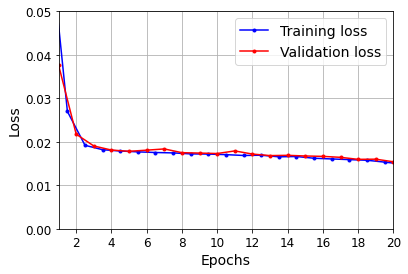

In [ ]:
# Visualization of Training Loss and Validation Loss

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
# Compute MSE and Compare to MSE from Other Algorithms

mse_lstm = model.evaluate(X_valid, y_valid)

print('\nMSE - Last Value                                  : ', mse_last_value)
print('MSE - Simple Neural Network                       : ', mse_simple_nn)
print('MSE - Simple Recurrent Neural Network             : ', mse_simple_rnn)
print('MSE - Deep Recurrent Neural Network               : ', mse_deep_rnn)
print('MSE - Deep Recurrent Neural Network - Dense Layer : ', mse_deep_rnn_dense)
print('MSE - LSTM                                        : ', mse_lstm)

63/63 [==============================] - 0s 4ms/step - loss: 0.0030

MSE - Last Value                                  :  0.11083336
MSE - Simple Neural Network                       :  0.011821746826171875
MSE - Simple Recurrent Neural Network             :  0.0445365346968174
MSE - Deep Recurrent Neural Network               :  0.0028947098180651665
MSE - Deep Recurrent Neural Network - Dense Layer :  0.0032483567483723164
MSE - LSTM                                        :  0.0029851084109395742


# C. GRUs

In [ ]:
# Let's Try Solve the Problem using GRU

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

Epoch 1/100
219/219 [==============================] - 8s 24ms/step - loss: 0.0629 - val_loss: 0.0394
Epoch 2/100
219/219 [==============================] - 5s 21ms/step - loss: 0.0283 - val_loss: 0.0181
Epoch 3/100
219/219 [==============================] - 5s 21ms/step - loss: 0.0162 - val_loss: 0.0164
Epoch 4/100
219/219 [==============================] - 5s 21ms/step - loss: 0.0155 - val_loss: 0.0154
Epoch 5/100
219/219 [==============================] - 4s 20ms/step - loss: 0.0152 - val_loss: 0.0151
Epoch 6/100
219/219 [==============================] - 4s 20ms/step - loss: 0.0144 - val_loss: 0.0135
Epoch 7/100
219/219 [==============================] - 4s 19ms/step - loss: 0.0116 - val_loss: 0.0102
Epoch 8/100
219/219 [==============================] - 4s 20ms/step - loss: 0.0090 - val_loss: 0.0086
Epoch 9/100
219/219 [==============================] - 4s 20ms/step - loss: 0.0083 - val_loss: 0.0085
Epoch 10/100
219/219 [==============================] - 5s 21ms/step - loss: 0.008

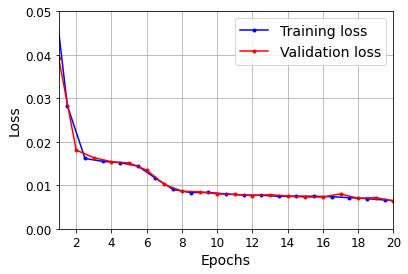

In [ ]:
# Visualization of Training Loss and Validation Loss

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
# Compute MSE and Compare to MSE from Other Algorithms

mse_gru = model.evaluate(X_valid, y_valid)

print('\nMSE - Last Value                                  : ', mse_last_value)
print('MSE - Simple Neural Network                       : ', mse_simple_nn)
print('MSE - Simple Recurrent Neural Network             : ', mse_simple_rnn)
print('MSE - Deep Recurrent Neural Network               : ', mse_deep_rnn)
print('MSE - Deep Recurrent Neural Network - Dense Layer : ', mse_deep_rnn_dense)
print('MSE - LSTM                                        : ', mse_lstm)
print('MSE - GRU                                         : ', mse_gru)

63/63 [==============================] - 0s 4ms/step - loss: 0.0023

MSE - Last Value                                  :  0.11083336
MSE - Simple Neural Network                       :  0.011821746826171875
MSE - Simple Recurrent Neural Network             :  0.0445365346968174
MSE - Deep Recurrent Neural Network               :  0.0028947098180651665
MSE - Deep Recurrent Neural Network - Dense Layer :  0.0032483567483723164
MSE - LSTM                                        :  0.0029851084109395742
MSE - GRU                                         :  0.0023013984318822622


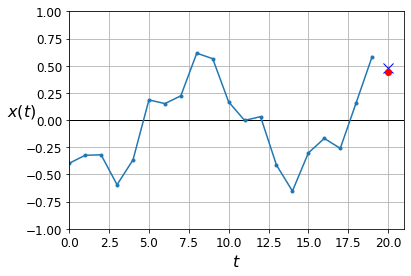

In [ ]:
# Visualization of Predictions for First Data

y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()